<a href="https://colab.research.google.com/github/MiaoHu17/Kickstarter_Project_Title_Classification/blob/main/Kickstarter_Project_Title_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


from keras import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Concatenate, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional

from tensorflow import keras
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import EarlyStopping

import os

import xgboost as xgb

from scipy.stats import chi2_contingency
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/flinks-data-challenge.csv').drop('Unnamed: 0',axis=1)
df = df.drop('sub_category',axis=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Since ***sub_category*** was selected after ***main_category***, therefore, this column should be dropped as it would be of no use in this case.

#**Data Cleaning**



## Check NAs

By checking the Non-Null Count in each column, it is clear that there are some NaN in Name column, those entries would be removed from the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323125 entries, 0 to 323124
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           323121 non-null  object
 1   goal           323125 non-null  object
 2   main_category  323125 non-null  object
 3   launched       323125 non-null  object
 4   deadline       323125 non-null  object
dtypes: object(5)
memory usage: 12.3+ MB


In [ ]:
df[df['name'].isnull()]

,name,goal,main_category,launched,deadline
142581,NaN,200000,Film & Video,2012-01-01 12:35:31,2012-02-29 15:04:00
262398,NaN,2000,Games,2012-12-19 23:57:48,2013-01-06 23:00:00
264745,NaN,2500,Design,2016-06-18 05:01:47,2016-07-18 05:01:47
289292,NaN,35000,Art,2011-11-06 23:55:55,2011-12-05 05:59:00


In [ ]:
df = df.dropna()

##Check each columns

In [ ]:
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

### Check ***launched*** and ***deadline*** columns

First, I checked the ***launched*** and ***dealine*** columns, and noticed that there are some entries that have different format than other entries (YYYY-MM-DD HH-MM-SS). And in both columns, the entries are the same. 

In [ ]:
df[df['launched'].apply(lambda x: len(x)!=19)]

,name,goal,main_category,launched,deadline
64370,CD: Heartsong Harmonics,2015-11-03 00:59:00,Music,7085,USD
85465,Everyday Beautiful,2015-03-27 01:00:00,Film & Video,2000,USD
98438,Hana Zara's new album,2015-03-03 02:04:57,Music,3000,USD
123282,Celebrating Joni Mitchell,2015-10-11 00:47:47,Music,5000,CAD
159139,Legal Highs,2014-11-05 03:00:57,Film & Video,5000,GBP
162775,Puppy Training Steps,2015-04-24 22:07:03,Film & Video,5000,USD
177308,Adventure to Peru's Sacred Valley,2015-03-21 21:13:23,Music,2200,USD


In [ ]:
df[df['deadline'].apply(lambda x: len(x)!=19)]

,name,goal,main_category,launched,deadline
64370,CD: Heartsong Harmonics,2015-11-03 00:59:00,Music,7085,USD
85465,Everyday Beautiful,2015-03-27 01:00:00,Film & Video,2000,USD
98438,Hana Zara's new album,2015-03-03 02:04:57,Music,3000,USD
123282,Celebrating Joni Mitchell,2015-10-11 00:47:47,Music,5000,CAD
159139,Legal Highs,2014-11-05 03:00:57,Film & Video,5000,GBP
162775,Puppy Training Steps,2015-04-24 22:07:03,Film & Video,5000,USD
177308,Adventure to Peru's Sacred Valley,2015-03-21 21:13:23,Music,2200,USD


Those entries are removed from the dataset.

In [ ]:
df = df[df['launched'].apply(lambda x: len(x)==19)]

After remove those entries, the rest of both columns are transformed into datetime format in order for further analysis

In [ ]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

It's clear that there are some errors in the ***launched*** column, (as the time was set to the Unix epoch), those records must be removed.

In [ ]:
df[['launched','deadline']].agg([min, max])

,launched,deadline
min,1970-01-01 01:00:00,2009-05-03 08:59:59
max,2016-12-06 10:18:31,2017-02-04 08:54:55


In [ ]:
df = df[df['launched'].apply(lambda x: x.year>2000)]

In [ ]:
df[['launched','deadline']].agg([min, max])

,launched,deadline
min,2009-04-21 21:02:48,2009-05-03 08:59:59
max,2016-12-06 10:18:31,2017-02-04 08:54:55


### Check ***goal*** column

As this column is a numerical column with integer, first thing to check is to see if there are any float format in this column

In [ ]:
def check_goal_float(x):
  try:
    x = int(x)
    return True
  except:
    return False

In [ ]:
df[~df['goal'].apply(lambda x: check_goal_float(x))]['goal'].unique()

array(['3397.98', '2732.8', '40373.6', '870.71', '4444.44', '851.66',
       '12524.22', '2999.99', '789.21', '6500.99', '2444.44', '1568.59',
       '1824.79', '14567.87', '55.56', '3218.28', '2222.22', '7654.32',
       '1.85', '1327.33', '2400.25', '47235.23', '12227.07', '10142.54',
       '4999.99', '3700.37', '911.11', '764.5', '27725.32', '8111.11',
       '17000.11', '1999.99', '5108.32', '15311.11', '147.1', '17628.64',
       '4857.33', '1777.74', '820.18', '3000.2', '333.33', '5555.55',
       '550.53', '2342.69', '255.65', '8101.01', '19453.5', '432.1',
       '6499.99', '6543.21', '376.83', '3333.33', '246.17', '99021.46',
       '33333.33', '19999.99', '1730.95', '5362.69', '114.8', '9999.99',
       '2134.59', '2247.31', '6306.91', '38013.05', '11111.11', '3141.59',
       '12015.21', '2399.99', '1903.62', '2527.11', '14725.72', '999.99',
       '3345.25', '372.27', '5532.09', '2834.79', '8572.5', '20.1',
       '4137.77', '1964.47', '4320.68', '12211.6', '4987.65', '566

In [ ]:
df['goal'] = df['goal'].apply(lambda x: float(x))

In [ ]:
#See the distribution of goal amount for each category
data_boxplot = []
main_category = df['main_category'].unique()
for item in main_category:
  temp = df[df['main_category']==item]
  temp = temp[['goal']]
  temp = np.array(temp)
  data_boxplot.append(temp)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


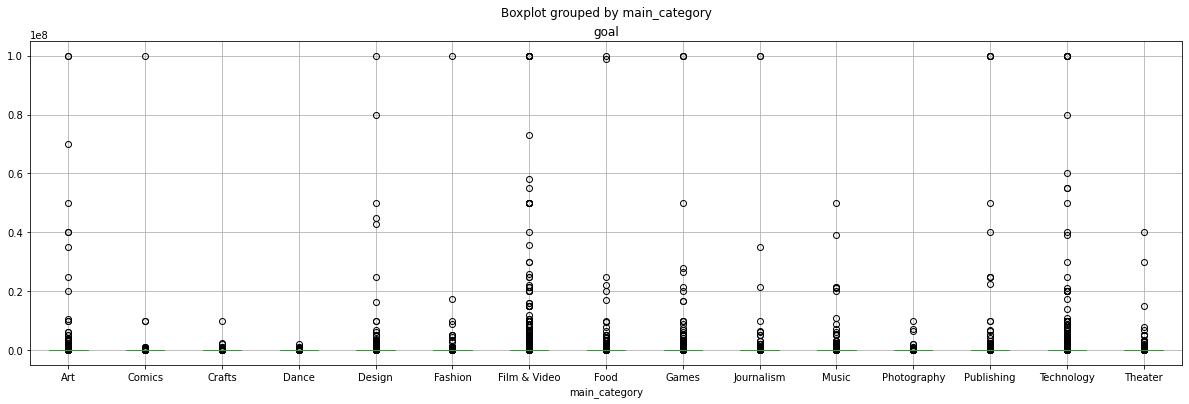

In [ ]:
df.boxplot(column='goal', by='main_category',figsize=(20,6))

From the plot above, there seems to be a few outliers that are above 80,000,000, and there are only 31 of them. 

In [ ]:
df[df['goal']>=80000000.0]

,name,goal,main_category,launched,deadline
20112,"Help me start a fair media company, Trump Media",100000000.0,Journalism,2016-11-22 06:41:27,2017-01-21 06:41:27
40859,FUCK Potato Salad. Paleo Potato Brownies!,99000000.0,Food,2014-07-09 00:24:34,2014-08-08 00:24:34
47000,Kybernan Holographic Gaming Network,100000000.0,Games,2015-11-07 00:57:17,2016-01-01 06:59:00
62208,Art Is Fabulous,100000000.0,Art,2016-04-06 02:55:07,2016-06-05 02:55:07
62382,Wax Apple,100000000.0,Film & Video,2014-12-16 15:43:58,2014-12-17 16:00:00
66368,Bring back Pontiac,100000000.0,Technology,2016-02-01 13:39:08,2016-04-01 13:39:08
80813,Survival SandBox Game (Canceled),100000000.0,Games,2016-05-10 07:20:30,2016-06-24 07:20:30
101047,Our future,100000000.0,Technology,2014-08-08 19:05:39,2014-10-07 19:05:39
121157,NAKED FASHION ART,100000000.0,Art,2015-05-01 19:40:34,2015-06-30 19:30:00
124629,Let's prove the earth is FLAT! (Suspended) (Su...,100000000.0,Journalism,2015-12-21 22:29:31,2016-01-20 22:29:31


In [ ]:
print(len(df[df['goal']>=80000000.0]))

31


As a result, those entries were removed from the data.

In [ ]:
df = df[df['goal']<80000000.0]

As the scale of ***goal*** is too wide, it is better to take a logarithm for this variable

In [ ]:
df['goal'] = df['goal'].apply(lambda x: np.log(x))

## Remove (Canceled) and (Suspended) from ***name*** and clean the ***name*** column

As shown in the last part, there are some special annotation that was not part of the name for example: (Canceled) and (Suspended). Therefore we need to remove them from the ***name***

In [ ]:
def removeCanSus(x):
  re_pattern = r'\(Canceled\)|\(Suspended\)'
  x = re.sub(re_pattern,'',x)
  x = x.strip()
  return x

In [ ]:
df['name'] = df['name'].apply(lambda x:removeCanSus(x))

Remove punctuations and remove extra spaces and tranform the strings into lower case

In [ ]:
# remove punctuations, digits and extra spaces
df['name'] = df['name'].apply(lambda x: re.sub(r'[^a-zA-Z\ ]',' ',x).strip())
df['name'] = df['name'].apply(lambda x: re.sub(r'\s+',' ',x).strip())

# Transform to lower case.
df['name'] = df['name'].apply(lambda x: x.lower())

Check name column with total length of strings less than 4, and found there are some strange and pretty ambiguous words, therefore those should be removed from the dataset.

In [ ]:
df[df['name'].apply(lambda x: len(x)<4)]

,name,goal,main_category,launched,deadline
263,lei,5.913503,Film & Video,2016-03-24 18:44:13,2016-04-17 00:00:00
619,one,9.210340,Film & Video,2014-08-30 09:06:44,2014-10-12 08:00:00
1055,ssk,8.411833,Publishing,2012-03-05 21:42:54,2012-04-19 21:42:54
2800,hi,9.210340,Technology,2015-02-26 18:59:26,2015-04-27 18:59:26
3717,xxx,7.607878,Fashion,2013-12-28 22:20:30,2014-01-13 06:00:00
...,...,...,...,...,...
322052,ph,8.517193,Art,2012-11-13 09:00:47,2012-12-04 09:00:47
322430,eti,6.907755,Games,2015-05-22 12:54:05,2015-06-21 12:54:05
322537,mbp,11.589887,Technology,2016-06-17 23:48:27,2016-08-16 23:48:27
322715,red,5.991465,Film & Video,2011-03-15 23:38:18,2011-05-06 06:00:00


What's more there are some entries only consists of single letters, those entries should be removed

In [ ]:
def removeOneLetterOnly(x):
  temp = re.sub(r'\b\w\b','',x)
  temp = re.sub(r'\s+','',temp)
  if len(temp) == 0:
    return temp
  else:
    return x

In [ ]:
df['name'] = df['name'].apply(lambda x: removeOneLetterOnly(x))
df = df[df['name'].apply(lambda x: len(x)>0)]

Also, I checked ***name*** with only one word, those words would have ambiguous, in this use case, it is better to exclude them from the model. As the total number of data entries in the dataset is 323,118, after remove those records we would still have sufficient number of data 

In [ ]:
df[df['name'].apply(lambda x: len(x.split())==1)]

,name,goal,main_category,launched,deadline
49,underwater,9.159047,Film & Video,2012-02-13 19:00:37,2012-03-26 06:00:00
141,sketches,6.907755,Publishing,2013-03-18 21:16:10,2013-04-07 22:16:10
152,covenant,10.373491,Music,2014-11-07 18:02:15,2014-12-07 18:02:15
161,risings,6.214608,Film & Video,2014-06-10 10:36:20,2014-07-10 10:36:20
194,high,8.565983,Film & Video,2016-06-02 04:55:34,2016-07-02 04:55:34
...,...,...,...,...,...
323054,fluxpanel,10.819778,Technology,2015-03-19 20:01:10,2015-04-18 21:01:10
323079,corporeal,6.214608,Dance,2013-04-25 01:59:29,2013-05-15 01:59:29
323100,loreto,9.392662,Film & Video,2014-05-06 23:50:34,2014-06-05 06:00:00
323102,transcaucasia,8.294050,Photography,2010-11-08 02:43:59,2011-01-08 02:43:59


Additionally, ***name*** with length less than 4 are usually meaningless

In [ ]:
df[df['name'].apply(lambda x: len(x)<4)]

,name,goal,main_category,launched,deadline
263,lei,5.913503,Film & Video,2016-03-24 18:44:13,2016-04-17 00:00:00
619,one,9.210340,Film & Video,2014-08-30 09:06:44,2014-10-12 08:00:00
1055,ssk,8.411833,Publishing,2012-03-05 21:42:54,2012-04-19 21:42:54
2800,hi,9.210340,Technology,2015-02-26 18:59:26,2015-04-27 18:59:26
3717,xxx,7.607878,Fashion,2013-12-28 22:20:30,2014-01-13 06:00:00
...,...,...,...,...,...
322052,ph,8.517193,Art,2012-11-13 09:00:47,2012-12-04 09:00:47
322430,eti,6.907755,Games,2015-05-22 12:54:05,2015-06-21 12:54:05
322537,mbp,11.589887,Technology,2016-06-17 23:48:27,2016-08-16 23:48:27
322715,red,5.991465,Film & Video,2011-03-15 23:38:18,2011-05-06 06:00:00


In [ ]:
#Remove the entries with total length of name smaller than 4. (As given above, they have ambiguous meaning)
df = df[df['name'].apply(lambda x: len(x)>=4)]
df = df[df['name'].apply(lambda x: len(x.split())>1)]

## Introduce "***duration***" variable

It's calculated by ***duration*** = ***deadline*** - ***launched***. The purpose to see if it's necessary to include the time-related variable into the models

In [ ]:
df['duration'] = df[['launched','deadline']].apply(lambda x: (x[1]-x[0]).days,axis=1)

In [ ]:
df = df.drop(['launched','deadline'],axis=1)

In [ ]:
df = df.reset_index(drop=True)

#Data Exploratory Analysis

Through the bar chart on the ***main_category*** column, we can see that the dataset is a highly imbalanced dataset.

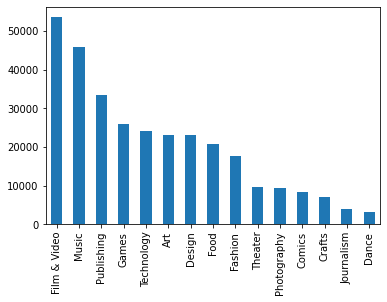

In [ ]:
df['main_category'].value_counts().plot.bar()

In [ ]:
df['main_category'].value_counts()

Film & Video    53542
Music           45833
Publishing      33358
Games           25896
Technology      24148
Art             23162
Design          23119
Food            20680
Fashion         17703
Theater          9633
Photography      9346
Comics           8262
Crafts           7012
Journalism       3922
Dance            3205
Name: main_category, dtype: int64

In [ ]:
df['duration'].agg([min, max])

min     1
max    92
Name: duration, dtype: int64

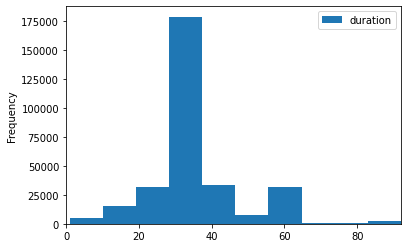

In [ ]:
df[['duration']].plot.hist(xlim=(0,92))

According to the box plot, all classes in main_category seems have similar distributions and similar median.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


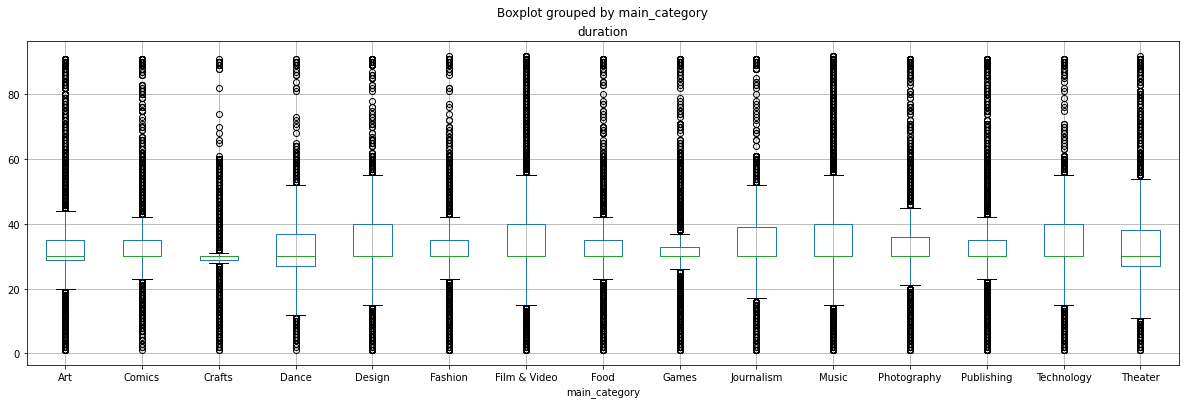

In [ ]:
df.boxplot(column='duration', by='main_category',figsize=(20,6))

By using Chi-Sqaure test and us eSelectKBest, it seems that these two variables are adequate for the model.

In [ ]:

chi2_values = []
p_values = []

categoricals = df[['duration','goal']]

for column in categoricals.columns:
    contingency = pd.crosstab(df[column], df['main_category'])

    chi2_val, p_value, degrees_of_freedom, expected = chi2_contingency(contingency)
    
    chi2_values.append(chi2_val)
    p_values.append(p_value)
    
data = list(zip(categoricals.columns, chi2_values, p_values))
pd.DataFrame(data = data,
             columns = ['Variable','Chi squared value','p-value'])

,Variable,Chi squared value,p-value
0,duration,13021.537585,0.0
1,goal,157068.454000,0.0


In [ ]:
SelectKBest(mutual_info_classif, k='all').fit(df[['goal','duration']], df['main_category']).scores_

array([0.08188614, 0.02112715])

Therefore, both ***duration*** and ***goal*** variables would be used in the models

# Models

First of all, I will try the classical machine learning models (Logistic Regression, Decision trees, random forests and XGboost) with TF-IDF, and then I will try one of the Deep Learning model (CNN).

## Machine Learning Models (Except for Neural Networks)

The reason to try classical machine learning models is that compared with deep learning models, they are simple and use less resources while has the potential of reaching a good performance 

### Textual data pre-processing and TF-IDF

As TF-IDF is a word-count based techniques, we would need to do extra preprocessing in order to use this techniques

In [ ]:
df_ml = df.copy(deep=True)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
def stemSent(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sent=[]
    for word in token_words:
        stem_sent.append(wordnet_lemmatizer.lemmatize(word, pos="n"))
    return " ".join(stem_sent)

In [ ]:
#Exclude all one letter word in the dataset and also Stem words to their root
df_ml['name'] = df_ml['name'].apply(lambda x: re.sub(r'\b\w\b','',x))
df_ml['name'] = df_ml['name'].apply(lambda x: re.sub(r'\s+',' ',x))
df_ml['name'] = df_ml['name'].apply(lambda x: stemSent(x))
df_ml['name'] = df_ml['name'].apply(lambda x: x.strip())
df_ml = df_ml[df_ml['name'].apply(lambda x: len(x.split())>1)]

In [ ]:
#TF-IDF
vectorizer = TfidfVectorizer(max_features = 10000, min_df = 10, max_df = 0.3,stop_words=stopwords.words('english'),sublinear_tf=True)
text_feature = vectorizer.fit_transform(df_ml['name'])

As ***goal*** has a range of [1,80000000) and ***duration*** has a range of [1,92], it is necessary to normalize them as the range of TF-IDF is [0,1]. Also, the *text_feature* was stored in the sparse matrix (csr_matrix), this is because there are so many words in the dataset, if we make the *text_feature* dense, it would take way more RAM, in order to save resources, we would also combine ***goal*** and ***duration*** in the sparse matrix

In [ ]:
#Normalize the 'goal' variable since the range of it is [1,80000000)
normalized_goal = (df_ml['goal'].values-min(df_ml['goal'].values))/(max(df_ml['goal'].values)-min(df_ml['goal'].values))
df_ml['goal'] = normalized_goal
#Normalize the 'duration' variable since the range of it is [1,80000000)
normalized_duration = (df_ml['duration'].values-min(df_ml['duration'].values))/(max(df_ml['duration'].values)-min(df_ml['duration'].values))
df_ml['duration'] = normalized_duration

#Combined the 'goal' and 'duration' variable with the sparse matrix
goal_ml = df_ml['goal'].values[:,None]
duration_ml = df_ml['duration'].values[:,None]
matrix_ml = hstack((text_feature,goal_ml,duration_ml))

### Divide the data into Train / Validation / Test sets

In [ ]:
#transform the target variable 'main_category' into numbers and keep the original label.
target_ml = df_ml['main_category'].factorize()[0]
index_list = df_ml['main_category'].factorize()[1]

In [ ]:
#Split the whole dataset into Train, Validation and Test set. with 60%, 20% and 20% of the whole dataset, respectively.
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(matrix_ml, target_ml, test_size=test_ratio, random_state=2020, stratify=target_ml)

valid_ratio_real = valid_ratio/(1-test_ratio)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_ratio_real, random_state=2020, stratify=y_train)

In [ ]:
print(X_train)

  (0, 1753)	0.4446828259821823
  (0, 3064)	0.5833143901137827
  (0, 5153)	0.4853132375511964
  (0, 9704)	0.4758913405602815
  (0, 10000)	0.6261674028766666
  (0, 10001)	0.31868131868131866
  (1, 834)	0.28994814672532604
  (1, 1394)	0.3745921129733367
  (1, 2664)	0.32543361535728393
  (1, 3992)	0.7596124736712586
  (1, 8560)	0.3044547141156438
  (1, 10000)	0.4764084143828414
  (1, 10001)	0.31868131868131866
  (2, 3373)	1.0
  (2, 10000)	0.46658312382078504
  (2, 10001)	0.2087912087912088
  (3, 9391)	1.0
  (3, 10000)	0.6036751096847507
  (3, 10001)	0.26373626373626374
  (4, 2153)	0.6254142151213644
  (4, 6191)	0.7802929318686207
  (4, 10000)	0.5302927822150189
  (4, 10001)	0.31868131868131866
  (5, 177)	0.33112211895166904
  (5, 1555)	0.4589610411065969
  :	:
  (184744, 10000)	0.5046700463811095
  (184744, 10001)	0.4065934065934066
  (184745, 2433)	0.872407175223578
  (184745, 3572)	0.48877982836694195
  (184745, 10000)	0.5858219722022845
  (184745, 10001)	0.26373626373626374
  (184746, 1

### Logistic Regression

In [ ]:
clf = LogisticRegression(random_state = 2020, solver='lbfgs', C=1, max_iter=500, class_weight='balanced').fit(X_train,y_train)

In [ ]:
print('The Accuracy on Validation Set is {:2.2%} for Logistic Regression'.format(clf.score(X_valid, y_valid)))

The Accuracy on Validation Set is 57.56% for Logistic Regression


In [ ]:
print(classification_report(y_valid, clf.predict(X_valid), target_names=index_list))

              precision    recall  f1-score   support

  Publishing       0.59      0.41      0.49      6657
Film & Video       0.73      0.50      0.59     10664
       Music       0.88      0.71      0.79      9153
        Food       0.73      0.79      0.76      4122
      Design       0.56      0.49      0.52      4611
      Crafts       0.28      0.54      0.37      1400
       Games       0.68      0.67      0.67      5157
      Comics       0.40      0.62      0.48      1647
     Fashion       0.67      0.68      0.67      3521
     Theater       0.35      0.58      0.43      1922
         Art       0.53      0.43      0.48      4620
 Photography       0.33      0.54      0.41      1864
  Technology       0.58      0.61      0.59      4808
       Dance       0.23      0.60      0.33       640
  Journalism       0.10      0.38      0.16       783

    accuracy                           0.58     61569
   macro avg       0.51      0.57      0.52     61569
weighted avg       0.63   

### Decision Tree

In [ ]:
clf1 = DecisionTreeClassifier(random_state = 2020, class_weight='balanced').fit(X_train, y_train)

In [ ]:
print('The Accuracy on Validation Set is {:2.2%} for Decision Tree'.format(clf1.score(X_valid, y_valid)))

The Accuracy on Validation Set is 44.76% for Decision Tree


In [ ]:
print(classification_report(y_valid, clf1.predict(X_valid), target_names=index_list))

              precision    recall  f1-score   support

  Publishing       0.42      0.37      0.39      6657
Film & Video       0.50      0.49      0.49     10664
       Music       0.74      0.65      0.69      9153
        Food       0.55      0.53      0.54      4122
      Design       0.33      0.27      0.30      4611
      Crafts       0.16      0.29      0.21      1400
       Games       0.55      0.47      0.51      5157
      Comics       0.33      0.48      0.39      1647
     Fashion       0.48      0.50      0.49      3521
     Theater       0.36      0.41      0.38      1922
         Art       0.35      0.34      0.35      4620
 Photography       0.28      0.35      0.31      1864
  Technology       0.38      0.37      0.38      4808
       Dance       0.16      0.44      0.24       640
  Journalism       0.06      0.11      0.08       783

    accuracy                           0.45     61569
   macro avg       0.38      0.40      0.38     61569
weighted avg       0.47   

### Random Forest

In [ ]:
clf2 = RandomForestClassifier(random_state = 2020, n_estimators = 200, class_weight='balanced').fit(X_train, y_train)

In [ ]:
print('The Accuracy on Validation Set is {:2.2%} for Random Forest'.format(clf2.score(X_valid, y_valid)))

The Accuracy on Validation Set is 54.30% for Random Forest


In [ ]:
print(classification_report(y_valid, clf2.predict(X_valid), target_names=index_list))

              precision    recall  f1-score   support

  Publishing       0.52      0.46      0.49      6657
Film & Video       0.49      0.62      0.55     10664
       Music       0.74      0.73      0.74      9153
        Food       0.65      0.68      0.66      4122
      Design       0.49      0.38      0.43      4611
      Crafts       0.32      0.31      0.31      1400
       Games       0.62      0.56      0.59      5157
      Comics       0.50      0.50      0.50      1647
     Fashion       0.58      0.60      0.59      3521
     Theater       0.49      0.43      0.45      1922
         Art       0.48      0.42      0.45      4620
 Photography       0.45      0.37      0.40      1864
  Technology       0.51      0.51      0.51      4808
       Dance       0.29      0.45      0.35       640
  Journalism       0.07      0.07      0.07       783

    accuracy                           0.54     61569
   macro avg       0.48      0.47      0.47     61569
weighted avg       0.55   

### Xgboost

In [ ]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

xg_cla = xgb.XGBClassifier(random_state = 2020, n_estimators =1000, n_jobs =-1)
xg_cla.fit(X_train,y_train)
preds = xg_cla.predict(X_valid)
print(classification_report(y_valid, preds, target_names=index_list))

              precision    recall  f1-score   support

  Publishing       0.62      0.48      0.54      6658
Film & Video       0.41      0.80      0.54     10667
       Music       0.82      0.75      0.78      9154
        Food       0.77      0.72      0.74      4122
      Design       0.58      0.43      0.50      4611
      Crafts       0.55      0.29      0.38      1399
       Games       0.76      0.60      0.67      5158
      Comics       0.76      0.46      0.57      1648
     Fashion       0.75      0.61      0.67      3522
     Theater       0.68      0.43      0.53      1923
         Art       0.57      0.44      0.50      4621
 Photography       0.65      0.38      0.48      1865
  Technology       0.58      0.56      0.57      4811
       Dance       0.71      0.43      0.54       641
  Journalism       0.38      0.06      0.11       783

    accuracy                           0.59     61583
   macro avg       0.64      0.50      0.54     61583
weighted avg       0.63   

In [ ]:
preds_test = xg_cla.predict(X_test)
print(classification_report(y_test, preds_test, target_names=index_list))

              precision    recall  f1-score   support

  Publishing       0.60      0.48      0.54      6657
Film & Video       0.41      0.81      0.55     10667
       Music       0.81      0.75      0.78      9154
        Food       0.78      0.71      0.75      4122
      Design       0.59      0.44      0.50      4612
      Crafts       0.59      0.32      0.42      1399
       Games       0.75      0.59      0.66      5159
      Comics       0.77      0.48      0.59      1648
     Fashion       0.74      0.61      0.67      3522
     Theater       0.69      0.44      0.54      1923
         Art       0.57      0.44      0.49      4621
 Photography       0.66      0.39      0.49      1865
  Technology       0.58      0.55      0.57      4811
       Dance       0.66      0.43      0.52       640
  Journalism       0.39      0.06      0.10       783

    accuracy                           0.60     61583
   macro avg       0.64      0.50      0.54     61583
weighted avg       0.63   

In [ ]:
preds = xg_cla.predict(X_valid)
f1_score(y_valid,preds, average='weighted')

0.5933920248848141

In [ ]:
f1_score(y_test,preds_test, average='weighted')

0.5946411559594624

## Deep Learning Models

Additionally, I will also try to implement a CNN model to classify the ***name*** along with ***goal*** and ***duration*** variable (As it's a short text classification.)

In [ ]:
df_dl = df.copy(deep=True)
df_dl['name'] = df_dl['name'].apply(lambda x: re.sub(r'\b\w\b','',x))
df_dl['name'] = df_dl['name'].apply(lambda x: re.sub(r'\s+',' ',x))
df_dl = df_dl[df_dl['name'].apply(lambda x: len(x.split())>1)]
MAX_SEQUENCE_LENGTH = max(df_dl['name'].apply(lambda x: len(x.split())))
MAX_NB_WORDS = 100000

In [ ]:
data_df = df_dl[['name','goal','duration']].values
target_ml = pd.get_dummies(df_dl['main_category'].values)

In [ ]:
#Split the whole dataset into Train, Validation and Test set. with 60%, 20% and 20% of the whole dataset, respectively.
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(data_df, target_ml, 
                                                    test_size=test_ratio, random_state=2020, stratify=target_ml)

valid_ratio_real = 0.2/(1-test_ratio)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=valid_ratio_real, random_state=2020, stratify=y_train)

Seperate the ***name*** from ***duration*** and ***goal*** for later use

In [ ]:
text_train = X_train[:,0]
additional_train = X_train[:,1:]

text_val = X_valid[:,0]
additional_val = X_valid[:,1:]

text_test = X_test[:,0]
additional_test = X_test[:,1:]

In [ ]:
f_row_train = (additional_train[:,0]-additional_train[:,0].mean())/additional_train[:,0].std()
s_row_train = (additional_train[:,1]-additional_train[:,1].mean())/additional_train[:,1].std()
normalized_additional_train = np.vstack((f_row_train,s_row_train)).transpose()

f_row_val = (additional_val[:,0]-additional_val[:,0].mean())/additional_val[:,0].std()
s_row_val = (additional_val[:,1]-additional_val[:,1].mean())/additional_val[:,1].std()
normalized_additional_val = np.vstack((f_row_val,s_row_val)).transpose()

f_row_test = (additional_test[:,0]-additional_test[:,0].mean())/additional_test[:,0].std()
s_row_test = (additional_test[:,1]-additional_test[:,1].mean())/additional_test[:,1].std()
normalized_additional_test = np.vstack((f_row_test,s_row_test)).transpose()

Implementing right padding and tokenize the textual data

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(text_train)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print('Shape of data tensor:', X.shape)

X_val = tokenizer.texts_to_sequences(text_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

X_test = tokenizer.texts_to_sequences(text_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

Found 85131 unique tokens.
Shape of data tensor: (184749, 18)


Implement pre-trained GloVe word embeddings to boost the model performance

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(word_index) + 2
EMBEDDING_DIM = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

--2020-12-31 03:30:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-31 03:30:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-31 03:30:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

As the dataset is imbalanced, class_weights are needed in order to deal with this problem

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',sorted(df_dl['main_category'].unique()),df_dl['main_category'].iloc[y_train.index])

class_weights = dict(enumerate(class_weights))

embedding_layer = Embedding(
    num_tokens,
    EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
inputText = Input(shape=(MAX_SEQUENCE_LENGTH,))
inputAdd = Input(shape=(2,))
text_embedding = embedding_layer(inputText)
text_embedding = SpatialDropout1D(0.2)(text_embedding)
text_embedding = Conv1D(200, 3, padding="same", activation="relu", strides=3)(text_embedding)
text_embedding = Conv1D(200, 3, padding="same", activation="relu", strides=3)(text_embedding)
text_embedding = GlobalMaxPooling1D()(text_embedding)
text_embedding = Dropout(0.2)(text_embedding)
combined = Concatenate(axis=1)([text_embedding, inputAdd])
res = Dense(202, activation='relu')(combined)
res = Dropout(0.25)(res)
res = Dense(101, activation='relu')(res)
res = Dropout(0.25)(res)
res = Dense(50, activation='relu')(res)
res = Dropout(0.25)(res)
res = Dense(30, activation='relu')(res)
res = Dropout(0.5)(res)
res = Dense(target_ml.shape[1], activation='softmax')(res)

In [ ]:
model = Model(inputs = [inputText, inputAdd], outputs=res)

In [ ]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 18, 200)      17026600    input_71[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_38 (SpatialDr (None, 18, 200)      0           embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_62 (Conv1D)              (None, 6, 200)       120200      spatial_dropout1d_38[0][0]       
___________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='auto', min_delta=0.00001, patience = 5)

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer='Adam', metrics=["acc"]
)

normalized_additional_train= np.asarray(normalized_additional_train).astype(np.float32)
normalized_additional_val = np.asarray(normalized_additional_val).astype(np.float32)


y_train = np.asarray(y_train)
model.fit([X,normalized_additional_train], y_train, batch_size=16, epochs=50,
          validation_data=([X_val,normalized_additional_val], y_valid),
          class_weight = class_weights, workers=-1,callbacks=es)

Epoch 1/50
11547/11547 [==============================] - 53s 5ms/step - loss: 2.0035 - acc: 0.3765 - val_loss: 1.5216 - val_acc: 0.5339
Epoch 2/50
11547/11547 [==============================] - 51s 4ms/step - loss: 1.6578 - acc: 0.5027 - val_loss: 1.4916 - val_acc: 0.5458
Epoch 3/50
11547/11547 [==============================] - 51s 4ms/step - loss: 1.6190 - acc: 0.5189 - val_loss: 1.4892 - val_acc: 0.5488
Epoch 4/50
11547/11547 [==============================] - 51s 4ms/step - loss: 1.6003 - acc: 0.5224 - val_loss: 1.4851 - val_acc: 0.5451
Epoch 5/50
11547/11547 [==============================] - 51s 4ms/step - loss: 1.5828 - acc: 0.5267 - val_loss: 1.4858 - val_acc: 0.5564
Epoch 6/50
11547/11547 [==============================] - 51s 4ms/step - loss: 1.5838 - acc: 0.5291 - val_loss: 1.4600 - val_acc: 0.5627
Epoch 7/50
11547/11547 [==============================] - 52s 4ms/step - loss: 1.5805 - acc: 0.5322 - val_loss: 1.4701 - val_acc: 0.5620
Epoch 8/50
11547/11547 [=================

In [ ]:
normalized_additional_test=np.asarray(normalized_additional_test).astype(np.float32)

preds = model.predict([X_test,normalized_additional_test])

In [ ]:
for i in range(len(preds)):
  temp = tf.one_hot(tf.argmax(preds[i]), depth = 15)
  preds[i] = temp

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.59      0.34      0.43      4621
           1       0.26      0.63      0.37      1648
           2       0.20      0.58      0.30      1399
           3       0.19      0.55      0.28       640
           4       0.57      0.27      0.37      4612
           5       0.61      0.63      0.62      3522
           6       0.78      0.40      0.53     10667
           7       0.65      0.83      0.73      4122
           8       0.60      0.66      0.63      5159
           9       0.08      0.48      0.14       783
          10       0.87      0.71      0.78      9154
          11       0.30      0.53      0.38      1865
          12       0.60      0.32      0.42      6657
          13       0.56      0.52      0.54      4811
          14       0.33      0.54      0.41      1923

   micro avg       0.52      0.52      0.52     61583
   macro avg       0.48      0.53      0.46     61583
weighted avg       0.62   

In [ ]:
preds_valid = model.predict([X_val,normalized_additional_val])

for i in range(len(preds_valid)):
  temp = tf.one_hot(tf.argmax(preds_valid[i]), depth = 15)
  preds_valid[i] = temp

f1_score(y_valid,preds_valid, average='weighted')

0.5479007146222981

#Conclusion and Future potential Works

| Model Name     | F1 Score |
|------------------------|------------|
| Logistic Regression | 57.56%  |
| Decision Tree    | 44.76%  |
| Random Forest    | 54.30%  |
| Xgboost       |  59.34%     |
| CNN         |  54.79%     |

The best model on validation set is XGBoost with 59.34% on test set. Therefore I tested it on the test set, the result(F-1 score) is around 59.46%.

This result is not optimal. Due to the limited resources and time, some methods or techniques are not tested. For example, for the text classification part, we could implement Transformer or Attention mechanism to achieve better results, but it would require more GPU resources. Additionally, for deep learning models, other pre-trained word embeddings (i.e.: Fasttext) would also be valuable (only GloVe used in this experiment) 

What's more, those models (Random Forest and XGBoost) are not tuned well enough, this is due to the fact that both models needs a long training time and due to the limitaiton of Colab, after going idle on the laptop, the colab would automatically disconnected, thus I cannot use gridsearch or manually grid search.

With regard to the feature engineering and selection, if given more time, some ways to try is to do feature engineering on ***goal*** and ***duration***, for exmaple, transform them into categorical variable for example for goal, we might have 1-1,000, 1,001-10,000,..., and so on. This might help us in this problem.
